In [1]:
import os.path
import random
from random import shuffle

import matplotlib.pyplot as plt
import pandas as pd

import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms

import numpy as np

random.seed(2)

# Load the Data 

In [2]:
index_file = "../dataset/pairs/perfect_broken_index.pkl"
path_broken = "../dataset/pairs/broken"
path_perfect = "../dataset/pairs/perfect"

df = pd.read_pickle(index_file)
df.head(5)

,file_broken
file_perfect,
Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orchestral_Suite_n2_1mov_12.png,Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orc...
Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orchestral_Suite_n2_1mov_12.png,Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orc...
Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orchestral_Suite_n2_1mov_12.png,Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orc...
Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orchestral_Suite_n2_1mov_12.png,Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orc...
Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orchestral_Suite_n2_1mov_12.png,Bach_Bwv10661069_Orchestral_Suites_Bwv1067_Orc...


In [3]:
transform = transforms.Compose([transforms.Resize((3508, 2480)), transforms.ToTensor(), transforms.Normalize(0.5, 0.5)])

In [4]:
max_images = df.size-1

images_broken_perfect = []

for i, file_perfect in enumerate(df.index):
    print(f"\r{i/len(df)}", end="")
    if max_images == 0:
        break
    
    files_broken = df.loc[file_perfect, "file_broken"]
    
    if files_broken is None or type(files_broken) == str:
        continue
        
    file_broken = files_broken.values[random.randint(0, len(files_broken.values)-1)] # Random "Broken" image
    images_broken_perfect.append((file_perfect, file_broken)) 
    max_images -= 1


print("\rDone")

0.54830671504008895647

KeyboardInterrupt: 

# Building train test and validation set

In [ ]:
train_test_val = (0.8, 0.1, 0.1)
limits = [int(x * len(images_broken_perfect)) for x in train_test_val]

shuffle(images_broken_perfect)

train_dataset = images_broken_perfect[:limits[0]]
test_dataset = images_broken_perfect[limits[0]:limits[0] + limits[1]]
valid_dataset = images_broken_perfect[limits[0] + limits[1]:]

print("Sizes: train", len(train_dataset), ", test", len(test_dataset), ", validation", len(valid_dataset))

In [ ]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)
valid_loader = DataLoader(valid_dataset)

# Train the model

In [7]:
import torch.nn.functional as F

class Denoiser(nn.Module):
    def __init__(self):
        super().__init__()
        # defining the encoder
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        
        # defining pooling  
        self.pool = nn.MaxPool2d(2,2)
        
        # defining the decoder
        self.conv2d_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.conv2d_2 = nn.Conv2d(64, 32, kernel_size=3, padding=1, stride=1)
        self.conv2d_3 = nn.Conv2d(32, 1, kernel_size=3, padding=1, stride=1)
    
    def forward(self, x):
        # passing the image through encoder
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # passing the encoded part through decoder
        x = F.relu(self.conv2d_1(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv2d_2(x))
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv2d_3(x))
        
        return x

model = Denoiser()
model

Denoiser(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [8]:
# defining the loss function
criterion = nn.MSELoss()

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
if torch.cuda.is_available():
    print('Cuda Available..Training on GPU')
    torch.backends.cudnn.benchmark =  True
    torch.backends.cudnn.enabled =  True
    model = model.cuda()
else:
	print('CUDA not available..Traning on CPU')

Cuda Available..Training on GPU


In [19]:
epochs = 5

training_loss = 0
min_valid_loss = np.Inf

cuda_available = torch.cuda.is_available()

save_file = "save/model.pt"

for epoch in range(epochs):
    print("Training")
    i = 0
    
    for file_perfect, file_broken in train_dataset:
        print("\rTrain", i, end="")
    
        try:       
            image_broken = Image.open(f"{path_broken}/{file_broken}").convert('L')
            image_perfect = Image.open(f"{path_perfect}/{file_perfect}").convert('L')
            image_broken = transform(image_broken).unsqueeze(0)
            image_perfect = transform(image_perfect).unsqueeze(0)
        except Exception as e:
            print(f"Problem with {file_perfect}, {file_broken}: {str(e)}\n\n")
            continue
    
        if cuda_available:
            image_broken, image_perfect = image_broken.cuda(), image_perfect.cuda()
        
        outputs = model(image_broken)
        loss = criterion(outputs, image_perfect)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
        
        i += 1
    
    print("Validating")
    i = 0
    
    with torch.no_grad():
        valid_loss = 0
        
        for file_perfect, file_broken in valid_dataset:
            print("\rValidate", i, end="")
            
            try:       
                image_broken = Image.open(f"{path_broken}/{file_broken}").convert('L')
                image_perfect = Image.open(f"{path_perfect}/{file_perfect}").convert('L')
                image_broken = transform(image_broken).unsqueeze(0)
                image_perfect = transform(image_perfect).unsqueeze(0)
            except Exception as e:
                print(f"Problem with {file_perfect}, {file_broken}: {str(e)}\n\n")
                continue
                    
            if cuda_available:
                image_broken, image_perfect = image_broken.cuda(), image_perfect.cuda()
        
            outputs = model(image_broken)
            loss = criterion(outputs, image_perfect)
            
            valid_loss += loss.item()
            
            i+=1 
    
        if valid_loss < min_valid_loss:
            print('Loss Decreased..({:.3f} -> {:.3f})  Saving Model..'.format(valid_loss, min_valid_loss))
            torch.save(model.state_dict(), save_file)
            min_valid_loss = valid_loss/len(valid_loader)
            
    print('Epoch: {}/{} -- Training Loss: {:.3f} -- Testing Loss: {:.3f}'.format(epoch+1, epochs, training_loss/len(train_loader), \
                                                                                 valid_loss/len(valid_loader)))

    training_loss = 0

Training
Train 25049Problem with Bach_Bwv232_Mass_23_1.png, Bach_Bwv232_Mass_23_1Shadow_Right.png: cannot identify image file '../dataset/pairs/broken/Bach_Bwv232_Mass_23_1Shadow_Right.png'


Train 36495Problem with Bach_Bwv232_Mass_23_1.png, Bach_Bwv232_Mass_23_1Shadow_Right.png: cannot identify image file '../dataset/pairs/broken/Bach_Bwv232_Mass_23_1Shadow_Right.png'


Train 37348Validating
Validate 4669Loss Decreased..(184.446 -> inf)  Saving Model..


NameError: name 'e' is not defined

In [20]:
model = Denoiser()
model.load_state_dict(torch.load(save_file))
model = model.cuda()

Bach_Bwv001_400_Chorales_014907b_2.png Bach_Bwv001_400_Chorales_014907b_2Hole_0.png


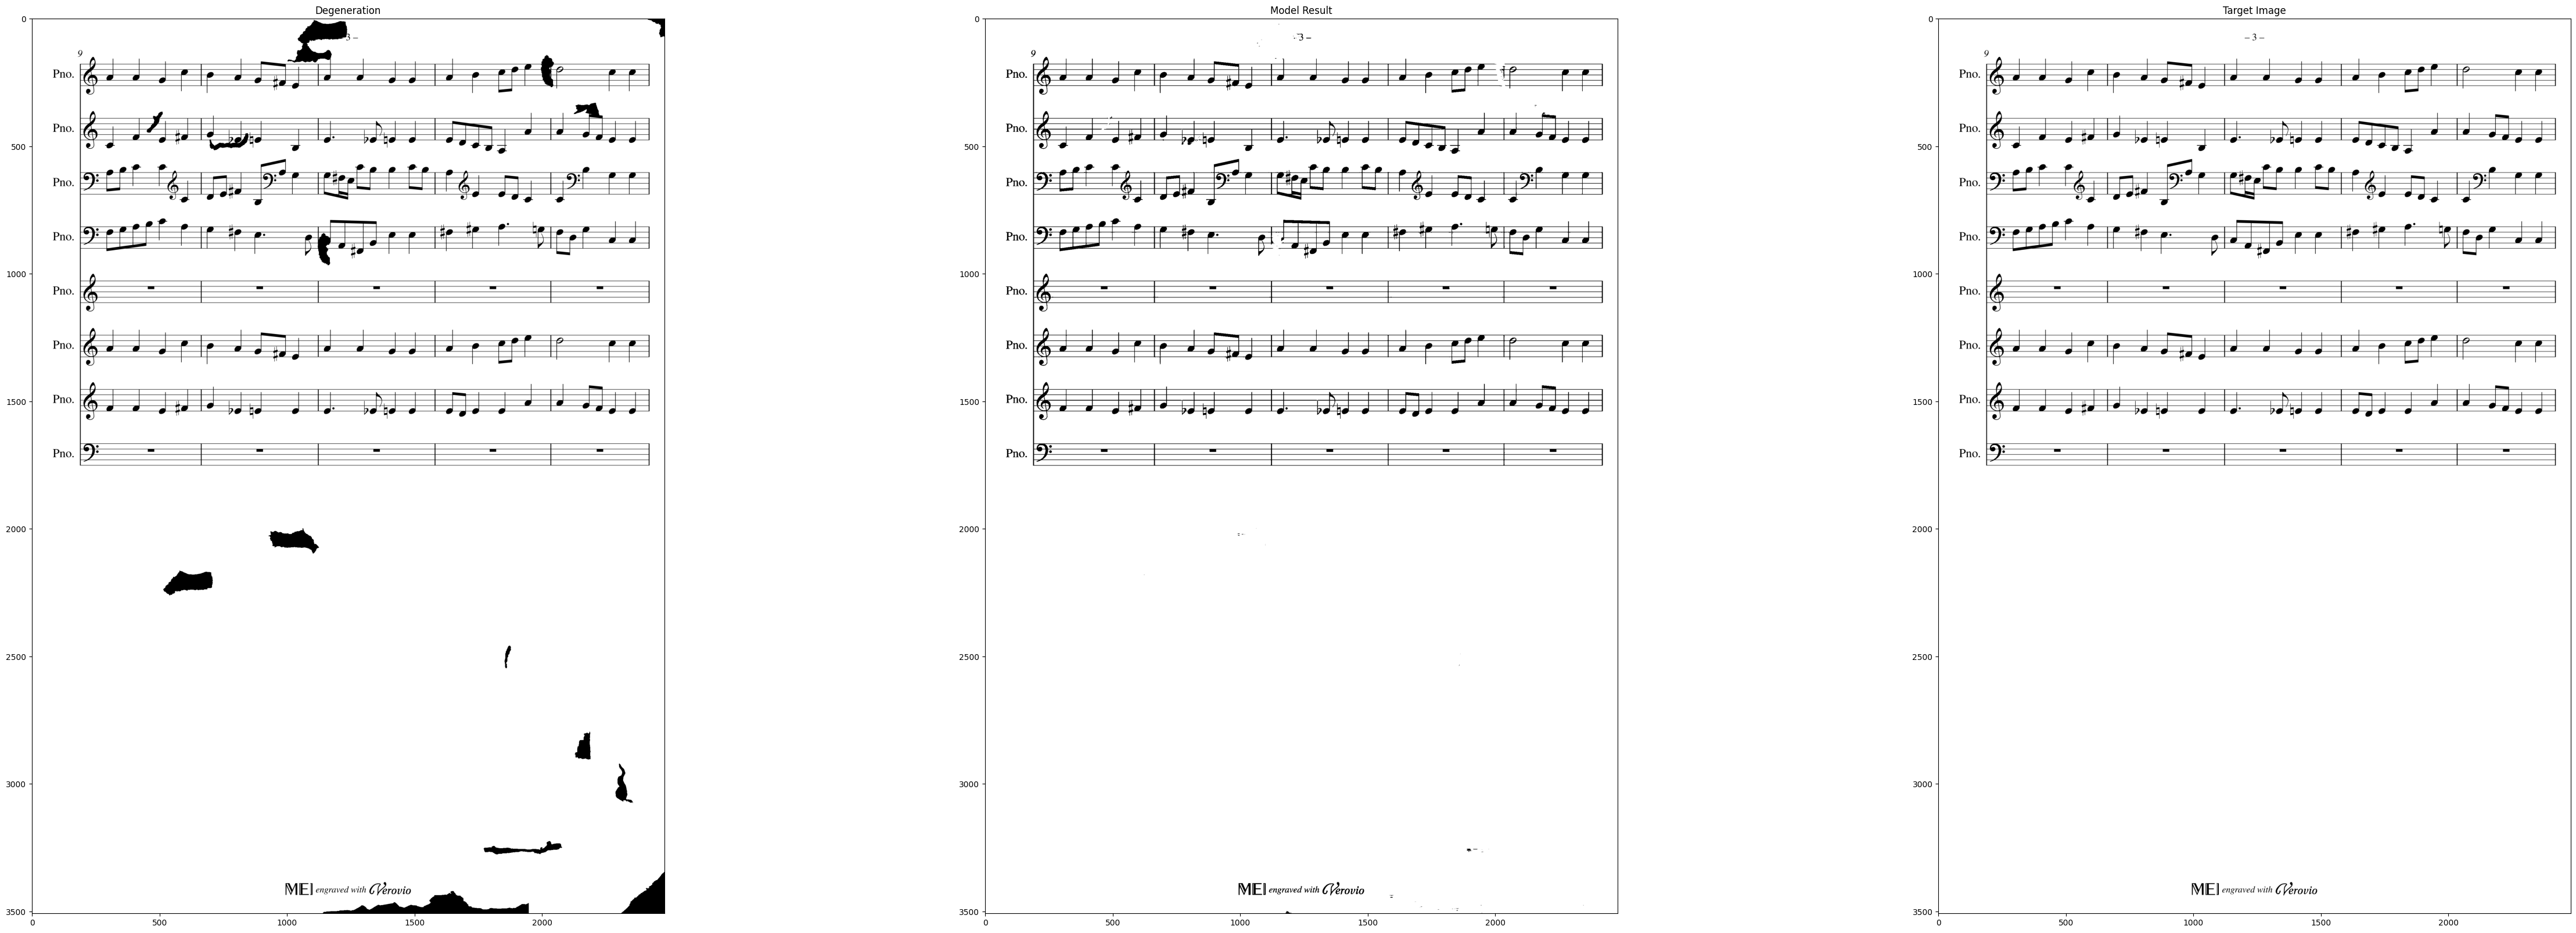

In [65]:
file_perfect, file_broken = test_dataset[36]

print(file_perfect, file_broken)

image_broken = Image.open(f"{path_broken}/{file_broken}").convert('L')
image_perfect = Image.open(f"{path_perfect}/{file_perfect}").convert('L')
#image_perfect = transform(image_perfect).unsqueeze(0).cuda()

tensor_broken = transform(image_broken).unsqueeze(0).cuda()
tensor_perfect = model(tensor_broken)
image_prediction = tensor_perfect.squeeze(0).cpu().detach().numpy()
image_prediction = ((0.5 *  image_prediction + 0.5) * 255).astype(np.uint8).squeeze()
image_prediction[image_prediction >= 200] = 255
image_prediction[image_prediction < 200] = 0
image_prediction = Image.fromarray(image_prediction).convert('RGB')

image_prediction.save("image.png")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))
ax1.imshow(image_broken.convert('RGB'))
ax1.set_title("Degeneration")
ax2.imshow(image_prediction)
ax2.set_title("Model Result")
ax3.imshow(image_perfect.convert('RGB'))
ax3.set_title("Target Image")

plt.savefig("test1.png")

In [ ]:
'''
test_pairs = []

for images, targets in test_loader:
    if cuda_available:
        images, targets = images.cuda(), targets.cuda()
    
    predictions = model(images)
    
    score = criterion(predictions, targets)
    
    test_pairs.append((images, targets, predictions.cpu(), score.cpu()))
'''

In [ ]:
import gc

# model.cpu()
del loss
gc.collect()
torch.cuda.empty_cache()